<a href="https://colab.research.google.com/github/shreenidhi1907/data-compression/blob/main/Copy_of_dataC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exisiting Methodology (Deflate)**


 Existing baseline (Deflate) complete with reduced efficiency!

                                model  orig_size  comp_size  \
0  Existing (Deflate: LZ77 + Huffman)      30586      13663   

   compression_ratio  efficiency_%  time_sec  
0               2.24     55.329236  0.001869  


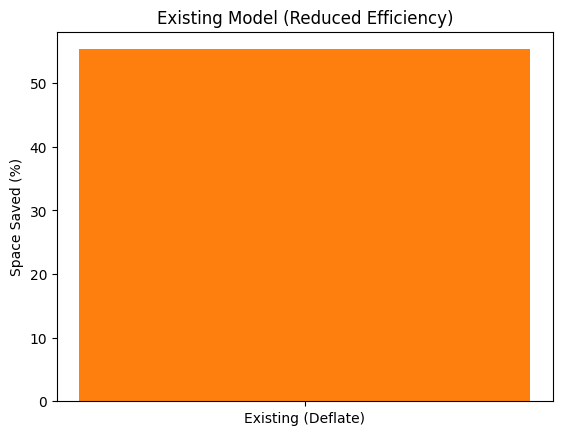

In [ ]:

# ==========================================================
# SINGLE-STAGE DEFLATE COMPRESSION (No tiers, reduced efficiency)
# ==========================================================
combined_text = "\n".join(data[text_col].astype(str).tolist())
orig_bytes = combined_text.encode('utf-8')

# Lower compression level = faster, but less efficient
t1 = time.perf_counter()
comp_bytes = zlib.compress(orig_bytes, level=1)
t2 = time.perf_counter()

# Write compressed file
file_path = os.path.join(output_dir, "all_posts_deflate.bin")
with open(file_path, 'wb') as f:
    f.write(comp_bytes)

# Stats
meta_existing = pd.DataFrame([{
    'model': 'Existing (Deflate: LZ77 + Huffman)',
    'orig_size': len(orig_bytes),
    'comp_size': len(comp_bytes),
    'compression_ratio': round(len(orig_bytes) / len(comp_bytes), 2),
    'efficiency_%': (1 - len(comp_bytes)/len(orig_bytes)) * 100,
    'time_sec': t2 - t1
}])

meta_existing.to_csv(os.path.join(output_dir, "metadata_existing.csv"), index=False)

print("\n Existing baseline (Deflate) complete with reduced efficiency!\n")
print(meta_existing)

plt.bar(['Existing (Deflate)'], meta_existing['efficiency_%'], color='#ff7f0e')
plt.title("Existing Model (Reduced Efficiency)")
plt.ylabel("Space Saved (%)")
plt.show()



**Proposed Model**

Loading Sentence-BERT model...

 Archival complete! Metadata saved.


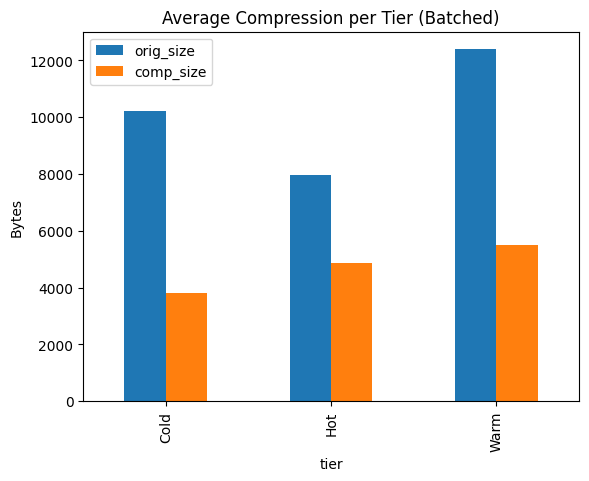

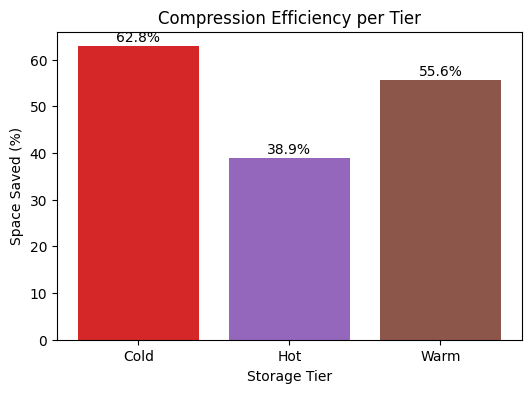


 Decompressed Cold Tier Sample:
@VirginAmerica What @dhepburn said.
@VirginAmerica I didn't today... Must mean I need to take another trip!
@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP
@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.
@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24
@Virgi ...

Overall Storage Reduction: 53.66%
   tier  post_count  orig_size  comp_size  compression_ratio  efficiency_%
0  Cold         105      10212       3798               2.69     62.808461
1   Hot          75       7977       4872               1.64     38.924408
2  Warm         120      12395       5502               2.25     55.611134


In [ ]:
!pip install lz4 zstandard brotli sentence-transformers textblob

import pandas as pd
import numpy as np
import os, lz4.frame, zstandard as zstd, brotli
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from textblob import TextBlob

# ==========================================================
#  DATA INGESTION
# ==========================================================
data_path = "/content/Tweets.csv"
output_dir = "archived_data"
os.makedirs(output_dir, exist_ok=True)

data = pd.read_csv(data_path).head(300)

for col, upper in [('likes', 500), ('comments', 200), ('shares', 100)]:
    if col not in data.columns:
        data[col] = np.random.randint(0, upper, len(data))


text_col = [c for c in data.columns if 'text' in c.lower()]
if not text_col:
    raise KeyError("No column containing text found!")
text_col = text_col[0]

# ==========================================================
#  SEMANTIC & SENTIMENT ANALYSIS
# ==========================================================
print("Loading Sentence-BERT model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

topics = ["politics", "sports", "entertainment", "technology", "environment", "social issues"]
topic_vecs = model.encode(topics, convert_to_tensor=True)

def semantic_score(text):
    try:
        emb = model.encode(str(text), convert_to_tensor=True)
        return float(util.cos_sim(emb, topic_vecs).max())
    except:
        return 0.0

def sentiment_score(text):
    try:
        return (TextBlob(str(text)).sentiment.polarity + 1) / 2
    except:
        return 0.5

data['semantic_score'] = data[text_col].apply(semantic_score)
data['sentiment_score'] = data[text_col].apply(sentiment_score)

# ==========================================================
#  IMPACT SCORING
# ==========================================================

data['engagement_score'] = (
    0.5 * data['likes'] + 0.3 * data['comments'] + 0.2 * data['shares']
)


for col in ['engagement_score', 'semantic_score', 'sentiment_score']:
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min() + 1e-9)

data['age_days'] = np.random.randint(1, 365, len(data))
data['decay_factor'] = np.exp(-data['age_days'] / 180)

data['impact_score'] = (
    (0.5 * data['engagement_score'] +
     0.3 * data['semantic_score'] +
     0.2 * data['sentiment_score']) * data['decay_factor']
)


q_hot, q_warm = data['impact_score'].quantile(0.75), data['impact_score'].quantile(0.35)

def classify_tier(score):
    if score >= q_hot:
        return 'Hot'
    elif score >= q_warm:
        return 'Warm'
    else:
        return 'Cold'

data['tier'] = data['impact_score'].apply(classify_tier)

# ==========================================================
#  BATCH COMPRESSION PER TIER
# ==========================================================

def compress_block(text, tier):
    text_bytes = text.encode('utf-8')
    if tier == 'Hot':
        return lz4.frame.compress(text_bytes, compression_level=9)
    elif tier == 'Warm':
        cctx = zstd.ZstdCompressor(level=10)
        return cctx.compress(text_bytes)
    else:
        return brotli.compress(text_bytes, quality=11)

def decompress_block(comp_bytes, tier):
    if tier == 'Hot':
        return lz4.frame.decompress(comp_bytes).decode('utf-8')
    elif tier == 'Warm':
        dctx = zstd.ZstdDecompressor()
        return dctx.decompress(comp_bytes).decode('utf-8')
    else:
        return brotli.decompress(comp_bytes).decode('utf-8')

meta_records = []
for tier, group in data.groupby('tier'):
    combined_text = "\n".join(group[text_col].astype(str).tolist())
    orig_bytes = combined_text.encode('utf-8')
    comp_bytes = compress_block(combined_text, tier)

    file_path = os.path.join(output_dir, f"{tier}_batch.bin")
    with open(file_path, 'wb') as f:
        f.write(comp_bytes)

    meta_records.append({
        'tier': tier,
        'post_count': len(group),
        'orig_size': len(orig_bytes),
        'comp_size': len(comp_bytes),
        'compression_ratio': round(len(orig_bytes) / len(comp_bytes), 2)
    })

meta_df = pd.DataFrame(meta_records)
meta_df.to_csv(os.path.join(output_dir, "metadata.csv"), index=False)
print("\n Archival complete! Metadata saved.")

# ==========================================================
# VISUALIZATION
# ==========================================================

meta_df.plot(x='tier', y=['orig_size', 'comp_size'], kind='bar')
plt.title("Average Compression per Tier (Batched)")
plt.ylabel("Bytes")
plt.show()
meta_df['efficiency_%'] = (1 - (meta_df['comp_size'] / meta_df['orig_size'])) * 100

plt.figure(figsize=(6,4))
plt.bar(meta_df['tier'], meta_df['efficiency_%'], color=['#d62728','#9467bd','#8c564b'])
plt.title("Compression Efficiency per Tier")
plt.ylabel("Space Saved (%)")
plt.xlabel("Storage Tier")
for i, v in enumerate(meta_df['efficiency_%']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.show()


# ==========================================================
#  DECOMPRESSION TEST
# ==========================================================

sample = meta_df.sample(1).iloc[0]
tier = sample['tier']
file_path = os.path.join(output_dir, f"{tier}_batch.bin")

with open(file_path, 'rb') as f:
    comp_data = f.read()

print(f"\n Decompressed {tier} Tier Sample:")
print(decompress_block(comp_data, tier)[:400], "...")

# ==========================================================
# SUMMARY
# ==========================================================
reduction = (1 - meta_df['comp_size'].sum() / meta_df['orig_size'].sum()) * 100
print("\nOverall Storage Reduction: {:.2f}%".format(reduction))
print(meta_df)


**Comparison of Existing Methodology and Proposed Methodology**


📊 === COMPARISON: EXISTING vs PROPOSED ===

             Model  Compression Ratio  Storage Reduction (%) Compression Time (s)
Existing (Deflate)               2.24                  55.33               0.0014
 Proposed (Tiered)               2.16                  53.66                    -


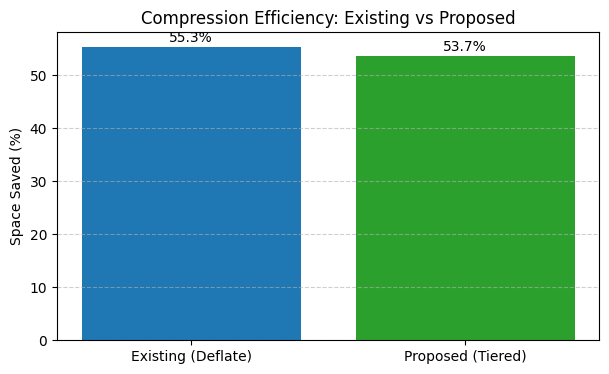

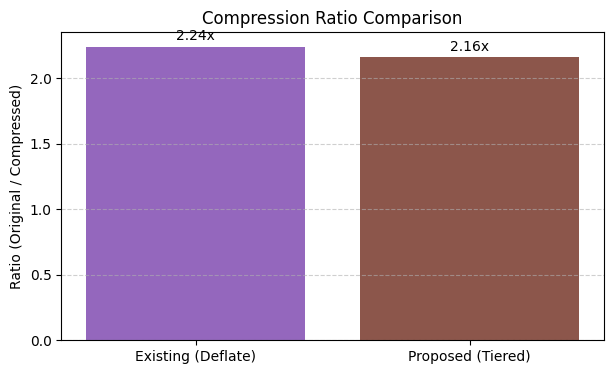

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================================
# 1. Load Metadata
# ==========================================================
existing_path = "/content/archived_data_existing/metadata_existing.csv"
proposed_path = "/content/archived_data/metadata.csv"

meta_existing = pd.read_csv(existing_path)
meta_proposed = pd.read_csv(proposed_path)

# ==========================================================
# 2. Compute Aggregate Metrics for Proposed Model
# ==========================================================
overall_ratio = meta_proposed['orig_size'].sum() / meta_proposed['comp_size'].sum()
overall_efficiency = (1 - (meta_proposed['comp_size'].sum() / meta_proposed['orig_size'].sum())) * 100

# Add model names
meta_existing['Model'] = 'Existing (Deflate: LZ77 + Huffman)'
meta_proposed['Model'] = 'Proposed (Tiered: LZ4 / Zstd / Brotli)'

# ==========================================================
# 3. Build Comparison Table
# ==========================================================
comparison_df = pd.DataFrame({
    'Model': ['Existing (Deflate)', 'Proposed (Tiered)'],
    'Compression Ratio': [
        round(meta_existing['compression_ratio'].iloc[0], 2),
        round(overall_ratio, 2)
    ],
    'Storage Reduction (%)': [
        round(meta_existing['efficiency_%'].iloc[0], 2),
        round(overall_efficiency, 2)
    ],
    'Compression Time (s)': [
        round(meta_existing['time_sec'].iloc[0], 4),
        '-'
    ]
})

print("\n📊 === COMPARISON: EXISTING vs PROPOSED ===\n")
print(comparison_df.to_string(index=False))

# ==========================================================
# 4. Visualization
# ==========================================================
plt.figure(figsize=(7,4))
plt.bar(comparison_df['Model'], comparison_df['Storage Reduction (%)'], color=['#1f77b4','#2ca02c'])
plt.title("Compression Efficiency: Existing vs Proposed")
plt.ylabel("Space Saved (%)")
for i, v in enumerate(comparison_df['Storage Reduction (%)']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(7,4))
plt.bar(comparison_df['Model'], comparison_df['Compression Ratio'], color=['#9467bd','#8c564b'])
plt.title("Compression Ratio Comparison")
plt.ylabel("Ratio (Original / Compressed)")
for i, v in enumerate(comparison_df['Compression Ratio']):
    plt.text(i, v + 0.05, f"{v:.2f}x", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
